# DIABETES PREDICTION
In this report, our primary objective is to uncover valuable insights pertaining to the multitude of factors that influence diabetes. To begin this endeavor, we will initiate by conducting a thorough examination of the dataset, aiming to gain a comprehensive understanding of its underlying structure. This preliminary analysis will encompass the identification of variable types, which may include continuous and categorical data, as well as an assessment of the dataset's overall size. Subsequently, we will delve into a comprehensive statistical analysis, which will encompass descriptive statistics and correlation analysis. Depending on the dataset's unique characteristics, we may also explore more advanced statistical techniques, all in pursuit of unveiling the significant factors intertwined with diabetes.

In [1]:
# Install necessary libraries------------------------------
# !pip install --upgrade --user --quiet pandas numpy matplotlib plotly seaborn scikit-learn tensorflow keras-tuner;

In [2]:
# Import necessary libraries------------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go #for interactive ROC curve plots
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ( confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from keras_tuner import Hyperband

In [3]:
# Set the seed for reproducibility------------------------------
np.random.seed(1)

# Load the data------------------------------
diabetes_data = pd.read_csv("diabetes.csv")

In [4]:
#Function to display dataframe without the index------------------------------
def display_dataframe(df):
    df.index = [''] * len(df)  # Set the index to empty strings
    return df

## UNDERSTANDING THE DATA

In [5]:
# Check Data Type------------------------------
#diabetes_data.info()
display_dataframe(pd.DataFrame({'Column Name': diabetes_data.columns, 'Data Type': diabetes_data.dtypes, 
              'Non-Null Count': diabetes_data.count(), 'Unique Count': diabetes_data.nunique()}))

Column Name Data Type  Non-Null Count  Unique Count
               Pregnancies     int64             768            17
                   Glucose     int64             768           136
             BloodPressure     int64             768            47
             SkinThickness     int64             768            51
                   Insulin     int64             768           186
                       BMI   float64             768           248
  DiabetesPedigreeFunction   float64             768           517
                       Age     int64             768            52
                   Outcome     int64             768             2

The dataset consists of 768 observations and 9 feature variables. The variables are as follows:
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration (mmol/L)
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skinfold thickness (mm)
- Insulin: Serum insulin levels(µh/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Integer variable (0 or 1) where 1 indicates the presence of diabetes and 0 indicates absence.

The data type of the response variable 'Outcome' is in integer format, but it is transformed into a categorical type for use in a binary classification predictive modelling.

In [6]:
diabetes_data['Outcome'] = diabetes_data['Outcome'].astype('category') 
display_dataframe(pd.DataFrame({'Column Name': diabetes_data.columns, 'Data Type': diabetes_data.dtypes, 
              'Non-Null Count': diabetes_data.count(), 'Unique Count': diabetes_data.nunique()}))

Column Name Data Type  Non-Null Count  Unique Count
               Pregnancies     int64             768            17
                   Glucose     int64             768           136
             BloodPressure     int64             768            47
             SkinThickness     int64             768            51
                   Insulin     int64             768           186
                       BMI   float64             768           248
  DiabetesPedigreeFunction   float64             768           517
                       Age     int64             768            52
                   Outcome  category             768             2

In [7]:
# Numerical summary------------------------------
print("\n **********Descriptive Statistics Summary********** \n")
diabetes_data.describe().T


 **********Descriptive Statistics Summary********** 



count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00

In [8]:
# Checking few rows of data------------------------------
print("\n **********Few Rows of Data********** \n")
display_dataframe(diabetes_data.head())


 **********Few Rows of Data********** 



Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
            6      148             72             35        0  33.6   
            1       85             66             29        0  26.6   
            8      183             64              0        0  23.3   
            1       89             66             23       94  28.1   
            0      137             40             35      168  43.1   

  DiabetesPedigreeFunction  Age Outcome  
                     0.627   50       1  
                     0.351   31       0  
                     0.672   32       1  
                     0.167   21       0  
                     2.288   33       1

In [9]:
# Checking for count of zero values------------------------------
print("\n **********Count of Zeros in Data********** \n")
(diabetes_data == 0).sum()


 **********Count of Zeros in Data********** 



Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

From the above numerical summary of the diabetes dataset, we can deduce several insights:

<!--Missing Values-->
- No missing or NA values observed in the dataset (768 entries for each variable).
<!--Outliers-->
- The substantial disparity observed between the 75th percentile and the maximum value suggests the presence of potential outliers, especially in features like 'Pregnancies,' 'Glucose,' 'BloodPressure,' 'SkinThickness,' 'Insulin,' 'BMI,' 'DiabetesPedigreeFunction,' and 'Age.'
<!--Data Distribution-->
<!--The mean values provide an indication of the central tendency of the data-->
- Features like 'Pregnancies' and 'Age' have low standard deviations, suggesting data points are close to the mean.
- Features like 'Insulin' and 'DiabetesPedigreeFunction' have higher standard deviations, indicating more variability.
<!--Zero Values-->
- Some features ('Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI') contain zero values, this is notable when the minimum value is zero. As we know these values cannot be zeroes, we will perform necessary processing with the data in the further steps. 
<!--Data Scaling-->
- Variability in feature scales, especially 'Insulin,' suggests the need for feature scaling before model training.
<!--Target Variable (Outcome)-->
- 'Outcome' is binary (0 or 1), indicating diabetes status.
- Approximately 35% of patients in the dataset have diabetes (mean of 'Outcome').
<!--Age Distribution-->
- 'Age' ranges from 21 to 81 years, with the majority falling between 24 and 41 years.

<!-- Next Steps
- Further explore feature relationships using boxplots and histograms.
- Handle zero values, consider feature scaling, and preprocess data for machine learning models.
- Train and evaluate machine learning models to predict diabetes.-->

In [10]:
# Remove rows with zeros in specified columns
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data = diabetes_data[(diabetes_data[columns_to_check] != 0).all(axis=1)]
diabetes_data.describe().T

count        mean         std     min       25%  \
Pregnancies               392.0    3.301020    3.211424   0.000   1.00000   
Glucose                   392.0  122.627551   30.860781  56.000  99.00000   
BloodPressure             392.0   70.663265   12.496092  24.000  62.00000   
SkinThickness             392.0   29.145408   10.516424   7.000  21.00000   
Insulin                   392.0  156.056122  118.841690  14.000  76.75000   
BMI                       392.0   33.086224    7.027659  18.200  28.40000   
DiabetesPedigreeFunction  392.0    0.523046    0.345488   0.085   0.26975   
Age                       392.0   30.864796   10.200777  21.000  23.00000   

                               50%      75%     max  
Pregnancies                 2.0000    5.000   17.00  
Glucose                   119.0000  143.000  198.00  
BloodPressure              70.0000   78.000  110.00  
SkinThickness              29.0000   37.000   63.00  
Insulin                   125.5000  190.000  846.00  
BMI                        33.2000   37.100   67.10  
DiabetesPedigreeFunction    0.4495    0.687    2.42  
Age                        27.0000   36.000   81.00

In [11]:
# Checking for near zero variance------------------------------
print("\n **********Near-Zero Variance Check********** \n")
#print(diabetes_data.drop('Outcome', axis=1).apply(lambda x: np.var(x) < 1e-3))
# Perform the operation and create a DataFrame
variance_check_df = pd.DataFrame({
    'Feature': diabetes_data.drop('Outcome', axis=1).columns,
    'Variance < 1e-3': diabetes_data.drop('Outcome', axis=1).apply(lambda x: np.var(x) < 1e-3)
})
display_dataframe(variance_check_df)


 **********Near-Zero Variance Check********** 



Feature  Variance < 1e-3
               Pregnancies            False
                   Glucose            False
             BloodPressure            False
             SkinThickness            False
                   Insulin            False
                       BMI            False
  DiabetesPedigreeFunction            False
                       Age            False

- All features have sufficient variance; there are no concerns regarding near-zero variance.

In [12]:
# Checking for missing values------------------------------
print("\n **********Missing Value Check********** \n")
display_dataframe(pd.DataFrame({'Column': diabetes_data.isnull().sum().index, 'Null Count': diabetes_data.isnull().sum().values}))


 **********Missing Value Check********** 



Column  Null Count
               Pregnancies           0
                   Glucose           0
             BloodPressure           0
             SkinThickness           0
                   Insulin           0
                       BMI           0
  DiabetesPedigreeFunction           0
                       Age           0
                   Outcome           0

- Verifying the presence of missing values in each feature reinforces our earlier findings based on the Descriptive Statistics Summary.

In [13]:
# Function to generate boxplots in a given color palette scheme------------------------------
def plot_boxplots(data, colors):
    for i, col in enumerate(data.columns):
        
        boxprops = dict(linewidth=2, color=colors[i % len(colors)])  # Box properties
        whiskerprops = dict(linewidth=2, linestyle='--', color=colors[i % len(colors)])  # Whisker properties
        capprops = dict(linewidth=2, color=colors[i % len(colors)])  # Caps properties
        medianprops = dict(linewidth=2, color=colors[i % len(colors)])  # Median line properties

        # Create the boxplot
        data.boxplot(column=col, ax=axes[i // 4, i % 4], 
                     boxprops=boxprops, whiskerprops=whiskerprops,
                     capprops=capprops, medianprops=medianprops)

        # Set axis labels and titles
        axes[i // 4, i % 4].set_ylabel('Values')
        axes[i // 4, i % 4].set_title(f'Box Plot for {col}')
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


 **********Box Plot********** 



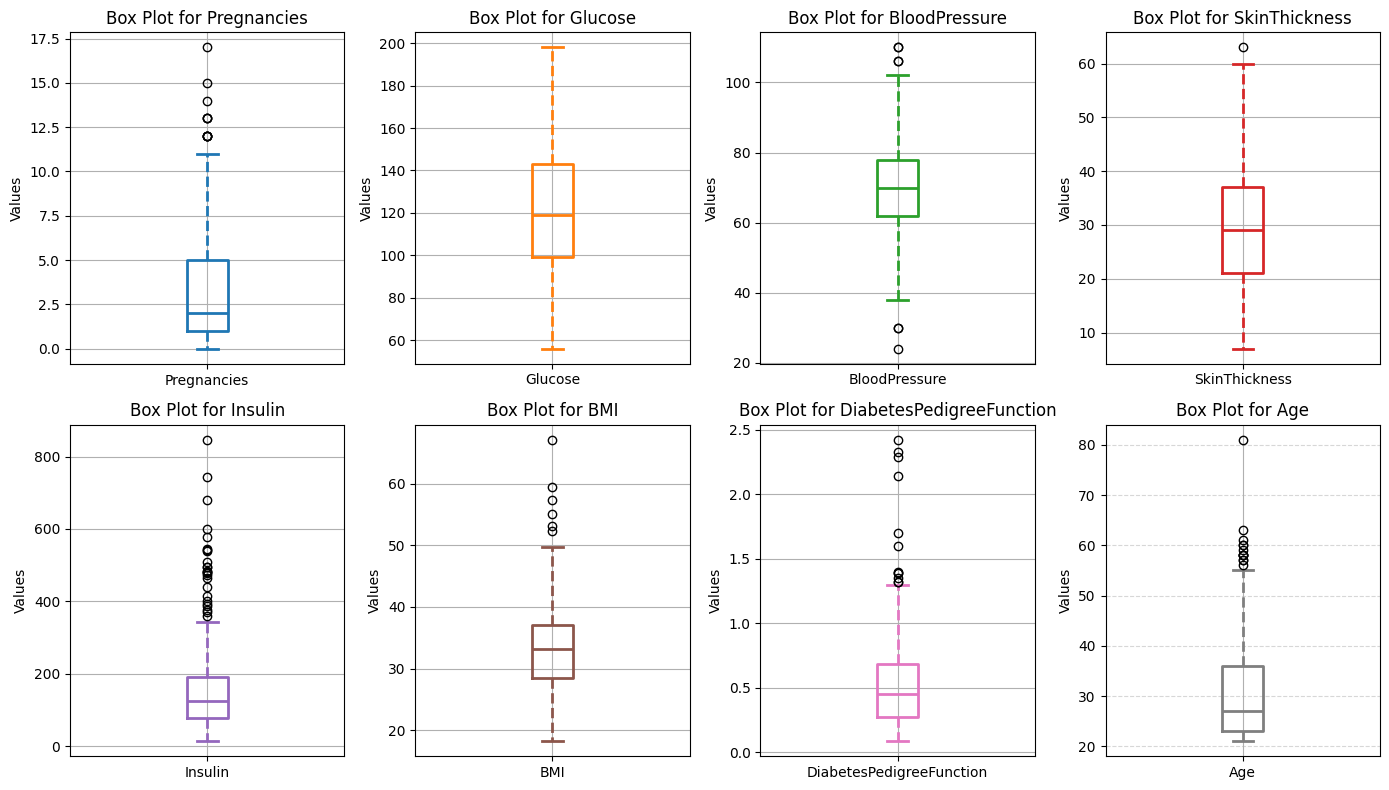

In [14]:
# Boxplots------------------------------
# Custom color palette we will follow for uniformity
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("\n **********Box Plot********** \n")
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
plot_boxplots(diabetes_data.drop(columns=['Outcome']), colors)

<!--Central Tendency-->
- Most medians are centrally located within the interquartile ranges, indicating a balanced distribution for many of the variables. However, the median for insulin is notably lower within its range, suggesting a skewed distribution.
<!--Spread-->
- The interquartile ranges vary, with blood pressure showing a narrow spread, indicating consistency among individuals, while insulin and age show a wider spread, indicating more variability.
<!--Outliers-->
- There are outliers in several variables, but they are notably present in the insulin, age, pregnancies and diabetes pedigree function variables. These outliers are predominantly high, indicating individual values that are significantly above the typical range for the dataset.
<!--Skewness-->
- Right-skewness is a common characteristic in this dataset, with variables such as pregnancies, insulin, diabetes pedigree function, and age showing a pronounced tail towards higher values. This suggests that while the majority of values are on the lower end, there are significant occurrences of higher values.
<!--Distribution-->
- The distributions of the variables generally show a tendency towards right-skewness, with the exception of blood pressure, which appears more symmetrical. This implies that, for most variables, there is a tail of higher values, even if the majority of the data is clustered around a central range.
<!---->
<!---->
<!---->
<!---->
<!---->

In [15]:
# Function to generate histogram plots for variables, in a given color palette scheme------------------------------
def plot_histograms(data, colors):
    for i, (col, color) in enumerate(zip(data.columns, colors)):
        sns.histplot(data[col], ax=axes[i // 2, i % 2], bins=20, kde=True, color=color, edgecolor='white')
        axes[i // 2, i % 2].set_title(col)

    sns.set_style("whitegrid")
    plt.tight_layout()
    plt.show()


 **********Histogram Plot********** 



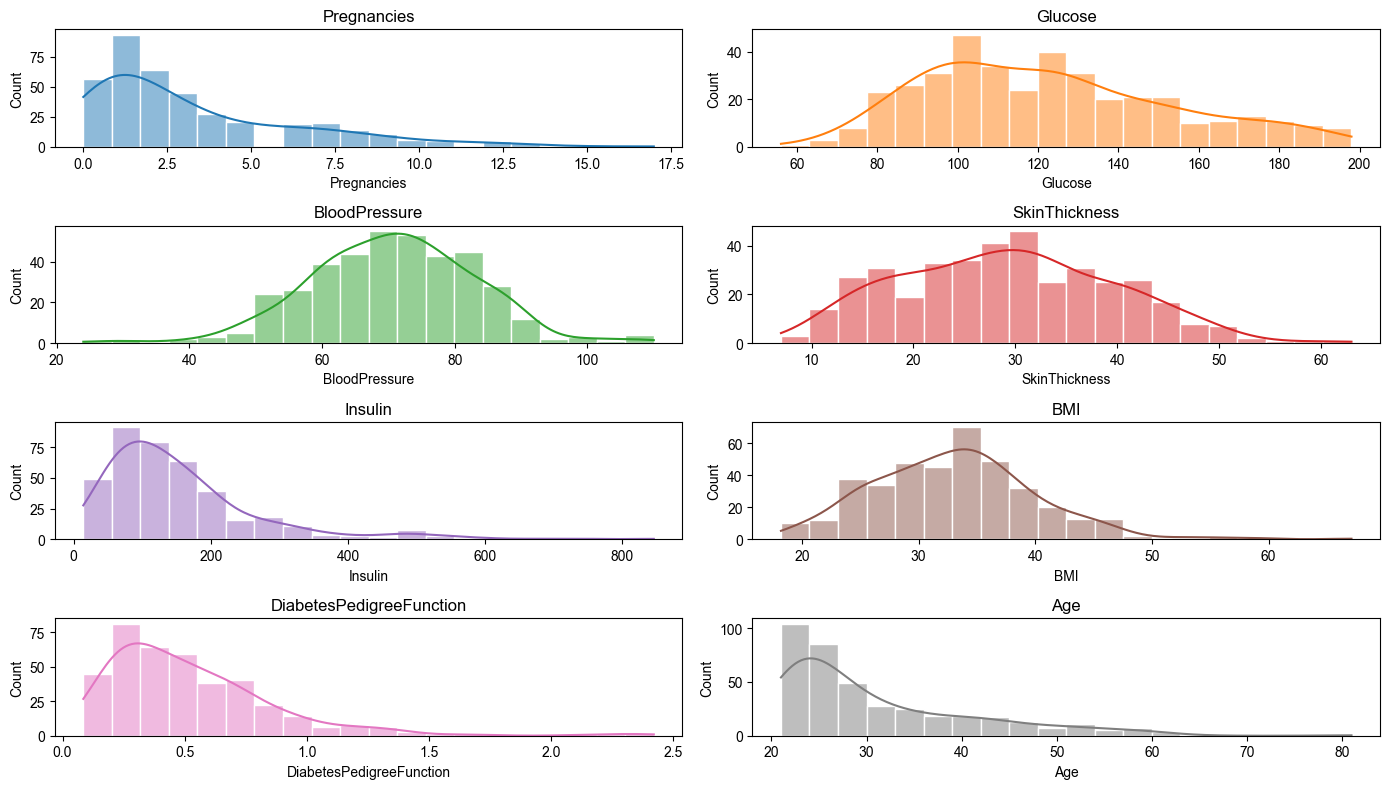

In [16]:
# Checking for distribution/center and skewness------------------------------
# Set the option to suppress use_inf_as_na warning
pd.set_option('mode.use_inf_as_na', False)
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn") 

# Distribution Check------------------------------
print("\n **********Histogram Plot********** \n")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 8))
plot_histograms(diabetes_data.drop(columns=['Outcome']), colors)

- The distributions of Glucose, Blood Pressure and BMI appear to be centered around the middle of the data range, suggesting symmetrical distributions.
- Specifically, Glucose and Blood Pressure exhibit a slight rightward shift from the center, indicating a higher average level of glucose and blood pressure in the population, respectively.
- Conversely, the distributions of Pregnancies, Skin Thickness, Insulin, Diabetes Pedigree Function (DPF) and Age are right-skewed, as evidenced by the extended right tails in the histograms.
- Notably, Age displays a left-leaning center, suggesting a younger population. 

For machine learning models, considering transformations to normalize the data or using models that can handle skewness would be beneficial. Additionally, the pronounced right skew in variables like Insulin may require more robust normalization techniques or non-parametric models that do not assume a normal distribution.

In [17]:
# Checking for skewness------------------------------
print("\n **********Skewness Values********** \n")
#print(diabetes_data.drop('Outcome', axis=1).apply(lambda x: x.skew()))
skew_values = diabetes_data.drop('Outcome', axis=1).apply(lambda x: x.skew())
display_dataframe(pd.DataFrame({'Feature': skew_values.index, 'Skewness': skew_values.values}).sort_values(by='Skewness', ascending=False))


 **********Skewness Values********** 



Feature  Skewness
                   Insulin  2.165116
  DiabetesPedigreeFunction  1.959101
                       Age  1.403607
               Pregnancies  1.335596
                       BMI  0.663485
                   Glucose  0.517850
             SkinThickness  0.209311
             BloodPressure -0.087516

- Most health features show a rightward skew, indicating that the bulk of the population has values below the mean, with Insulin and DPF exhibiting particularly high skewness, highlighting a significant subset of the population with markedly high readings.
- Age and Pregnancies are moderately right-skewed, suggest a population that is generally younger with fewer pregnancies, but includes older individuals and those with multiple pregnancies.
- Blood Pressure exhibits a slight negative skewness, though the distribution is largely balanced, hinting at a small propensity for higher values.
- BMI and Glucose display moderate positive skewness, with a minor prevalence of higher-than-average measurements.

The skewness in key health parameters may influence medical interventions and predictive modeling, necessitating data normalization or specialized algorithms to account for the distribution bias.



 **********Correlation Plot********** 



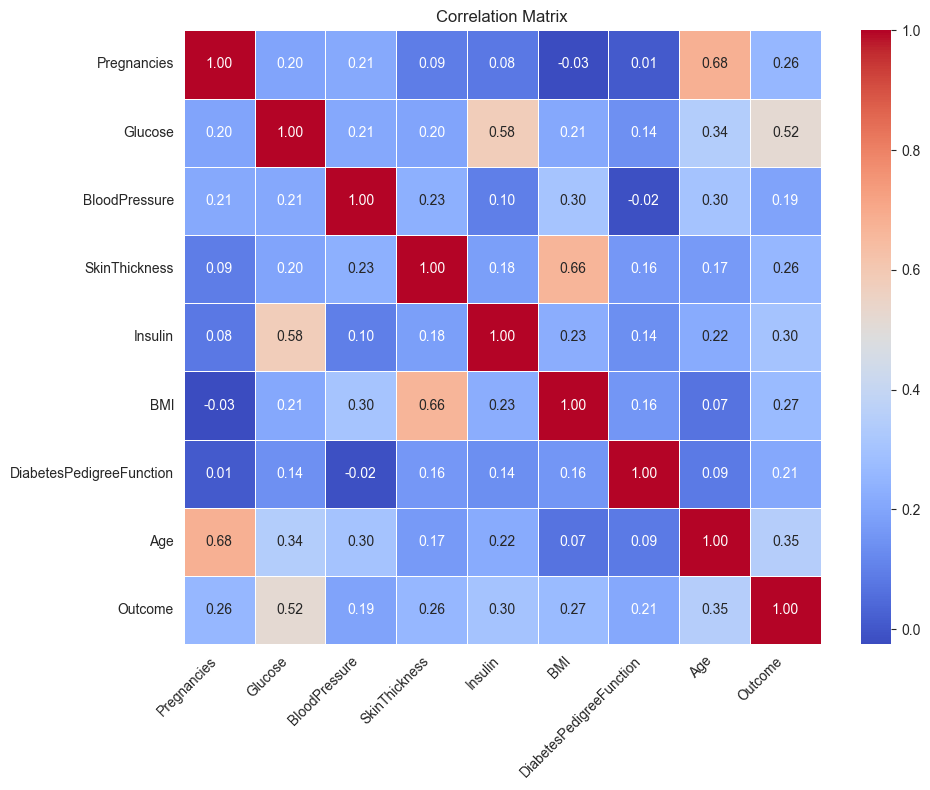

In [18]:
# Checking for correlated predictors------------------------------
print("\n **********Correlation Plot********** \n")
corr_matrix = diabetes_data.corr()
fig, ax = plt.subplots(figsize=(10, 8))

# Define a color palette (e.g., "coolwarm")
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".2f", linewidths=.5, ax=ax)
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(corr_matrix.columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

- The highest correlation with diabetes presence is glucose levels (0.52), suggesting that higher glucose levels are a strong indicator of diabetes.
- Age and Insulin also shows a significant correlation (0.35 & 0.3 respectively) with diabetes outcome, indicating that risk increases with age and higher glucose levels.
- There's a moderate correlation (~0.26) between pregnancies, skin thickness, BMI and the presence of diabetes, indicating a relationship between physical body features and number of pregnancies and the risk of developing diabetes.
- We also observe a moderate correlation between factors like Age and the number of Pregnancies, BMI and Skin Thickness as well as between Insulin and Glucose.
- Fortunately, we do not identify any highly correlated features in our dataset that would require removal.

The analysis highlights several key factors associated with diabetes, such as glucose levels, age, insulin levels, the number of pregnancies, BMI and skin thickness, some of them align with medical understanding of diabetes risk factors. These insights can help in the further detailed analysis, such as logistic regression to predict diabetes risk or to explore the impact of these factors more deeply.


 **********Scatter Plot********** 



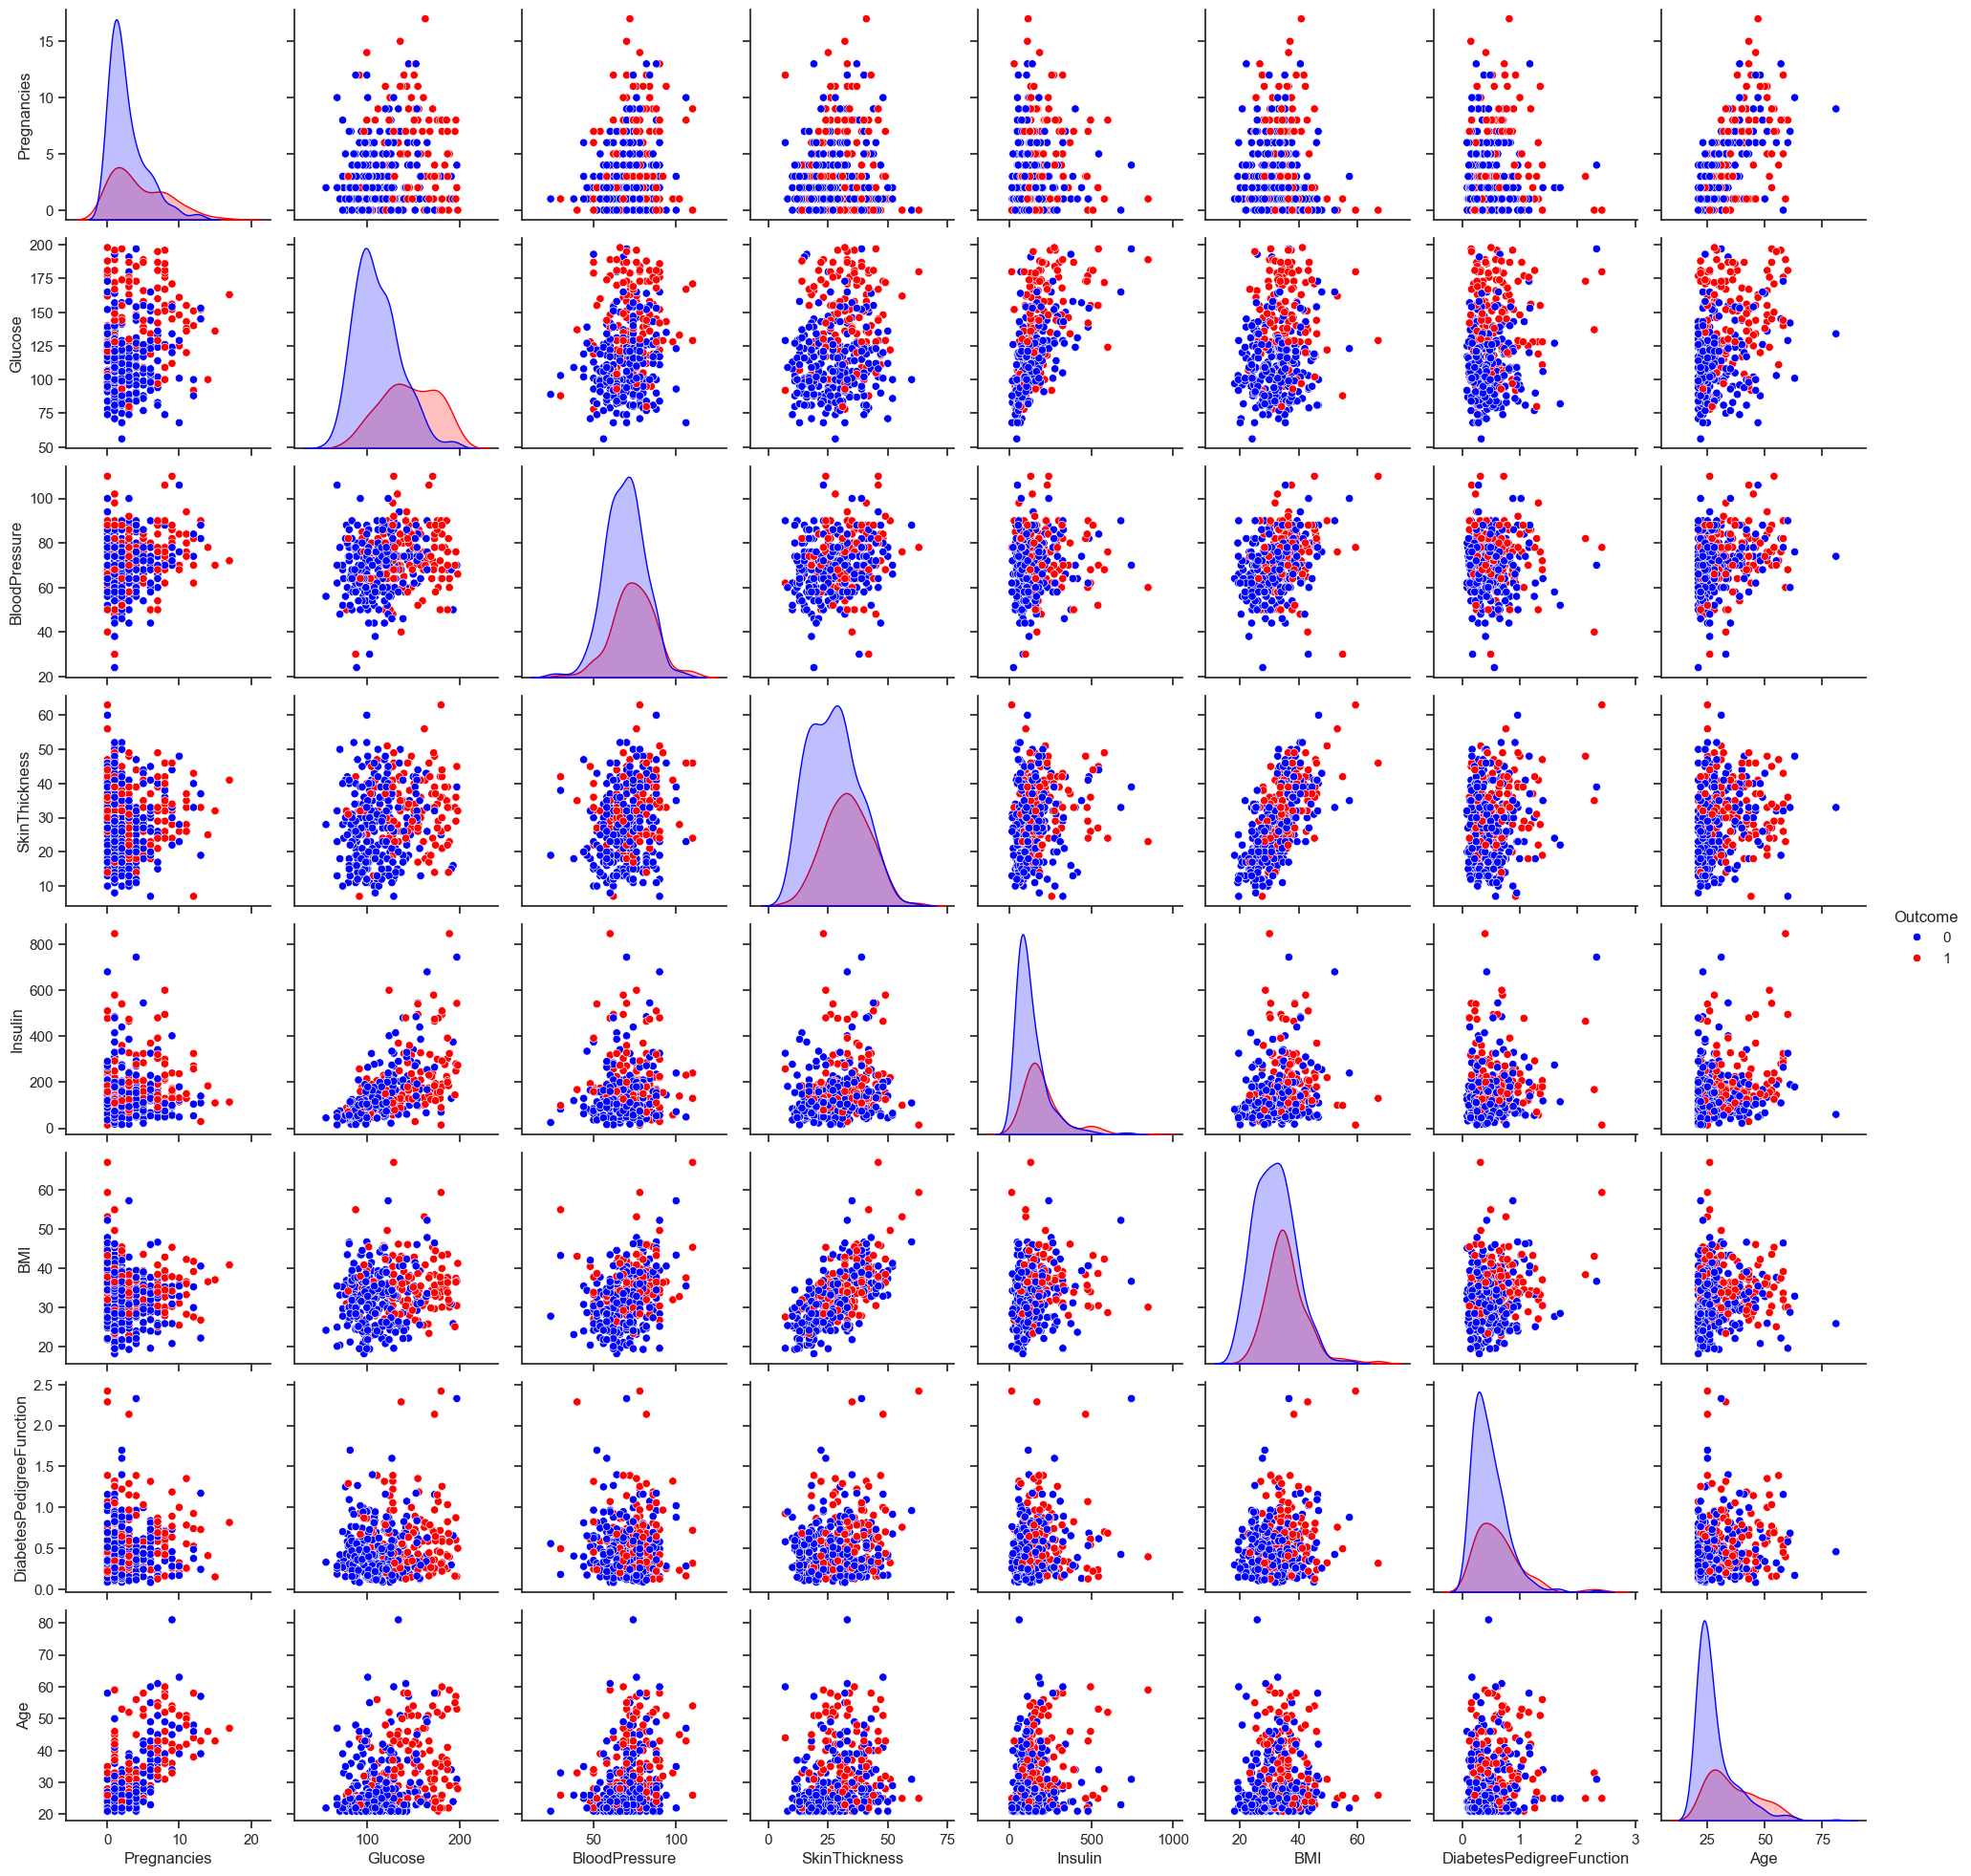

In [19]:
# Scatter Plot Summary------------------------------
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

print("\n **********Scatter Plot********** \n")
# Set the style of the plot
sns.set(style="ticks")

# Create the pair plot
sns.pairplot(diabetes_data, hue="Outcome", palette={0: "blue", 1: "red"})

# Show the plot
plt.show()

Scatter plots offer an intuitive way to assess patterns and trends in data. We note the following in our dataset:
<!--Relationship between continuous variables-->
- We observe a correlation between factors like Age and the number of Pregnancies, BMI and Skin Thickness as well as between Insulin and Glucose but by examining the pattern of points in the subplots with and without Diabetes, we can infer that, for most variables, there are no strong correlation or trend between them.
<!--Correlation Assessment-->
<!--The clustering or dispersion of points on a scatter plot can provide insights into the strength and direction of the correlation between the two variables-->
<!--- Visually we see a strong positive correlation between variables Insulin and Glucose, BMI and Skin Thickness.
<!--Outlier Detection-->
<!--Outliers, or data points that significantly deviate from the general pattern, are easily identifiable on scatter plots.-->
- There are multiple variables with potential outliers; above tests and evaluations also confirm this.
<!--Distribution of Data-->
<!--Scatter plots can reveal the distribution of data along both axes-->
<!--- Patterns like clusters, gaps, or groupings in some variables hint at underlying structures or subpopulations. This insight prompts further exploration for a nuanced understanding of the data.-->
<!--Identifying Trends and Patterns-->
<!--Trends, patterns, and shapes in scatter plots can highlight underlying structures or relationships in the data-->
<!--- For example, we see a linear trend between BMI and Skin Thickness and hence may suggest a linear relationship between the variables, while clusters mainly due to zero values may indicate distinct groups within the data.-->


 **********Response Variable Distribution********** 



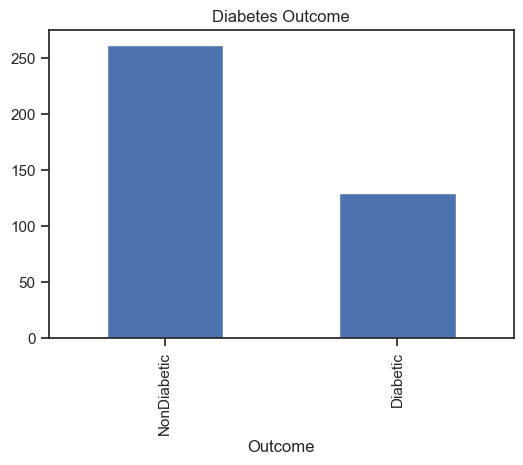

In [20]:
# Check if the distribution among the response variable classes is not vastly different------------------------------
print("\n **********Response Variable Distribution********** \n")
diabetes_data['Outcome'] = diabetes_data['Outcome'].map({0: 'NonDiabetic', 1: 'Diabetic'})
diabetes_data['Outcome'].value_counts().plot(kind='bar', title='Diabetes Outcome', figsize=(6, 4))
plt.show()

- There is a noticeable imbalance between the two classes, with non-diabetic outcomes being more prevalent than diabetic outcomes.
- When evaluating machine learning models using this data, metrics beyond accuracy, such as F1-score, precision or AUC-ROC, may be necessary to fully understand model performance given the class imbalance.

In [21]:
# Transform ------------------------------
# Use Yeo-Johnson transformation instead of Box-Cox due to presence of zeros in Pregnancy data, i.e. patients who haven't been pregnant is possible
transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson', PowerTransformer(method='yeo-johnson'), diabetes_data.columns[:-1])
    ],
    remainder='passthrough'
)

# Apply the transformation
transformed_data = transformer.fit_transform(diabetes_data.drop('Outcome', axis=1))

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data, columns=diabetes_data.columns[:-1])
print("\n **********Few Rows of Transformed Data********** \n")
display_dataframe(transformed_df.head())


 **********Few Rows of Transformed Data********** 



Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
    -0.679722 -1.163269      -0.389294      -0.538382 -0.402541 -0.677637   
    -1.639676  0.574434      -2.372525       0.593776  0.436887  1.371217   
     0.266180 -1.703899      -1.630983       0.324459 -0.496577 -0.218606   
    -0.124712  2.001230      -0.069687       1.441888  2.192231 -0.295072   
    -0.679722  1.840088      -0.862120      -0.538382  2.875572 -0.357016   

  DiabetesPedigreeFunction       Age  
                 -1.477242 -1.481170  
                  2.484524  0.634297  
                 -0.950749 -0.285265  
                 -1.542083  1.658737  
                 -0.190345  1.796740

In [22]:
# Checking for skewness after the transformation------------------------------
print("\n **********Skewness Check********** \n")
#print(transformed_df.apply(lambda x: x.skew()))
skew_values = transformed_df.apply(lambda x: x.skew())
display_dataframe(pd.DataFrame({'Feature': skew_values.index, 'Skewness': skew_values.values}).sort_values(by='Skewness', ascending=False))


 **********Skewness Check********** 



Feature  Skewness
                       Age  0.214510
  DiabetesPedigreeFunction  0.080712
             BloodPressure  0.051875
               Pregnancies  0.004328
                   Glucose  0.003667
                       BMI  0.001598
                   Insulin  0.001513
             SkinThickness -0.053678

- The data transformation seems to have been effective in normalizing the features, which should theoretically improve the performance of parametric models that assume normally distributed input data. 

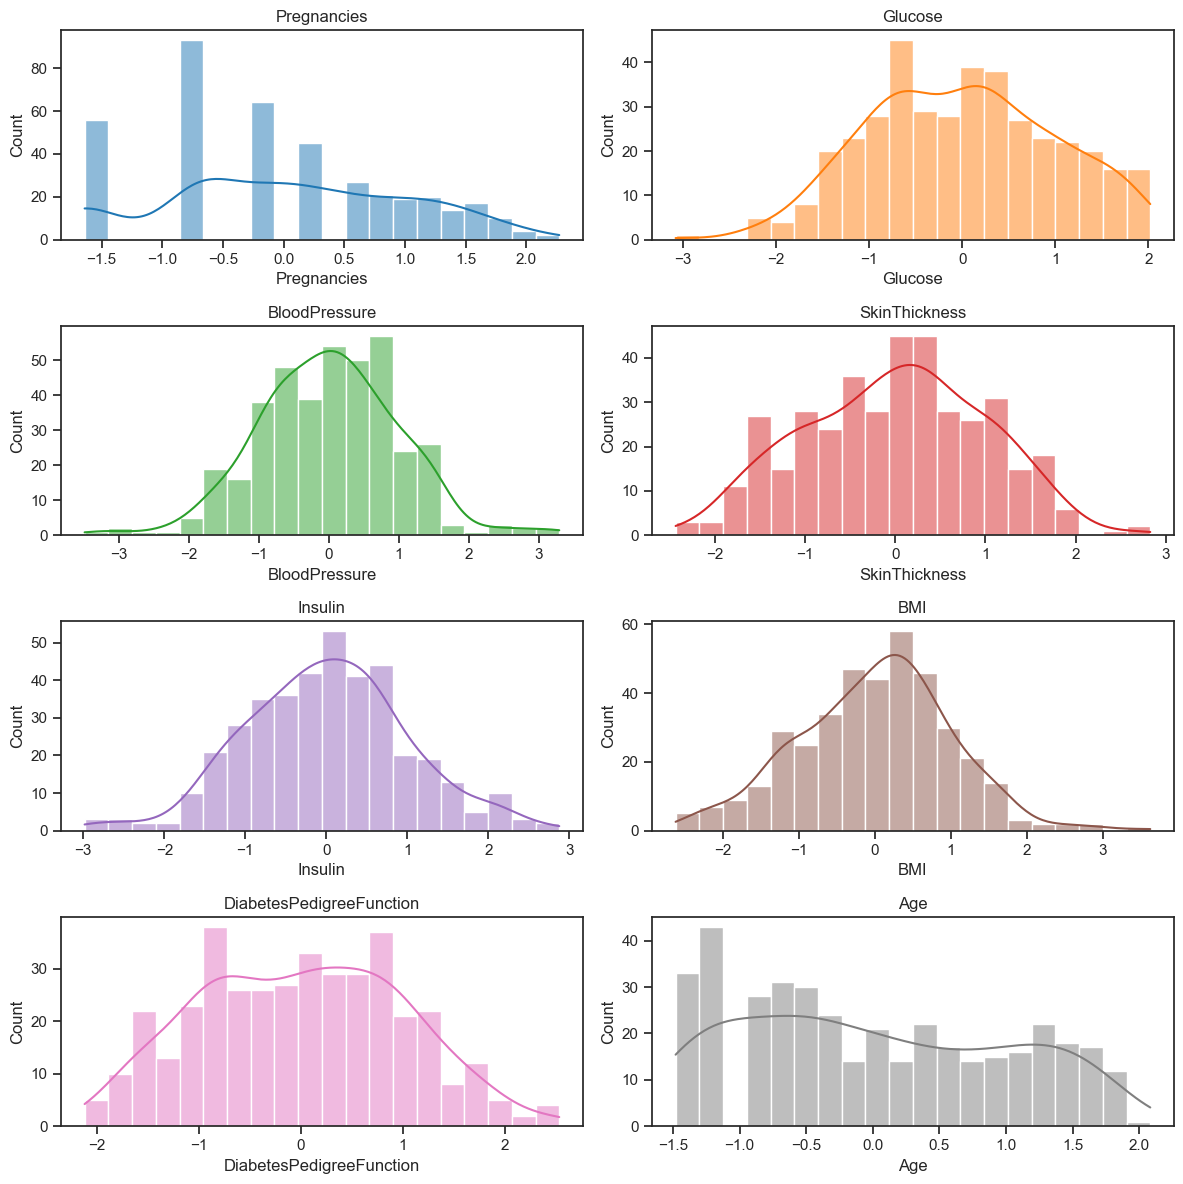

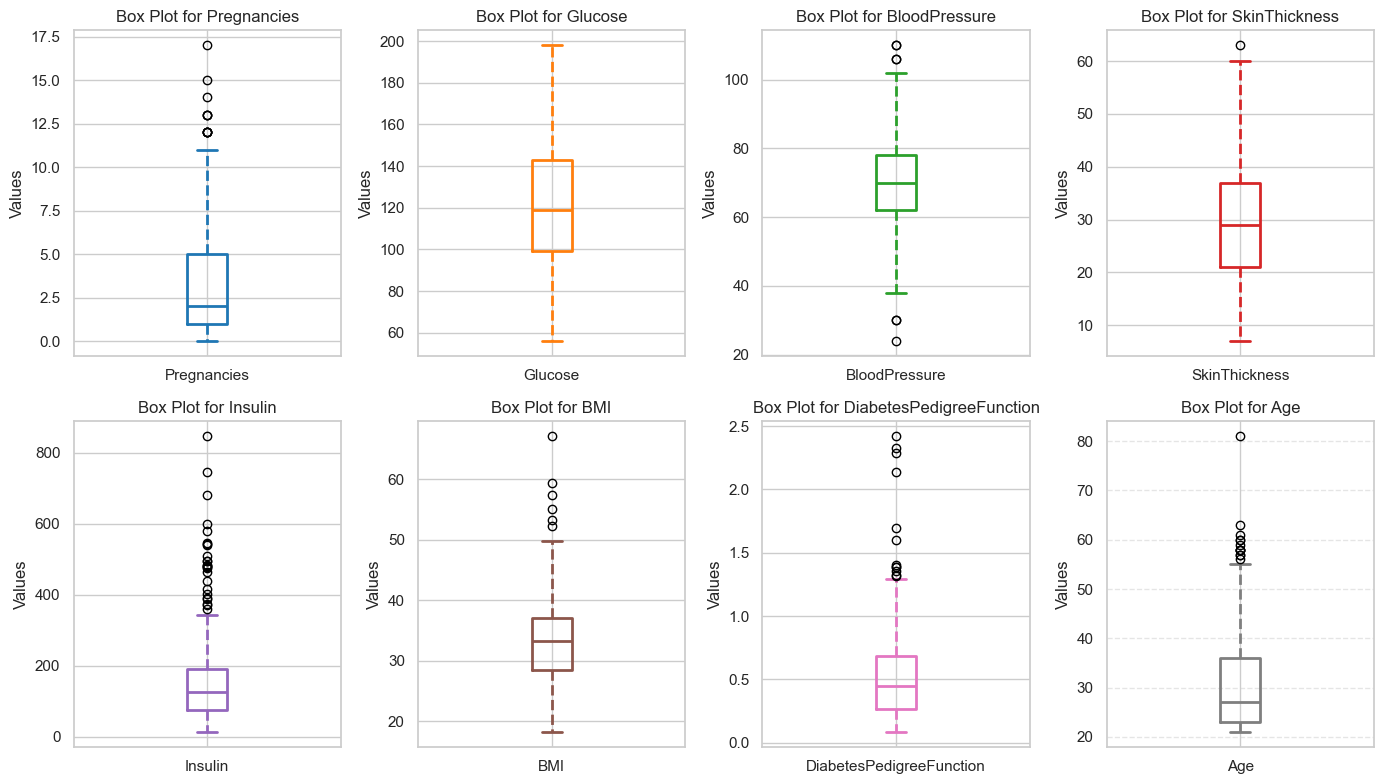

In [23]:
# Checking for distribution/center after the transformation------------------------------
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
plot_histograms(transformed_df, colors)

# Boxplots------------------------------
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
plot_boxplots(diabetes_data.drop(columns=['Outcome']), colors)

- After transformation, several variables excluding Pregnancies and Age exhibit distributions that approximate normality. This is advantageous for machine learning models that assume normally distributed data.
- The variable Pregnancies and Age still shows an irregular distribution, which could be due to it being a count variable that may not inherently follow a normal distribution even after transformation.
- The data transformation process has been successful in reducing the number of outliers across most variables, which can often improve the performance of many machine learning models.
- Although the number of outliers is reduced, there are still some present in the variables. This is common as transformations cannot always normalize data completely, especially for variables with inherent discrete properties like "Pregnancies" or natural bounds like "Age".

## MODEL TRAINING

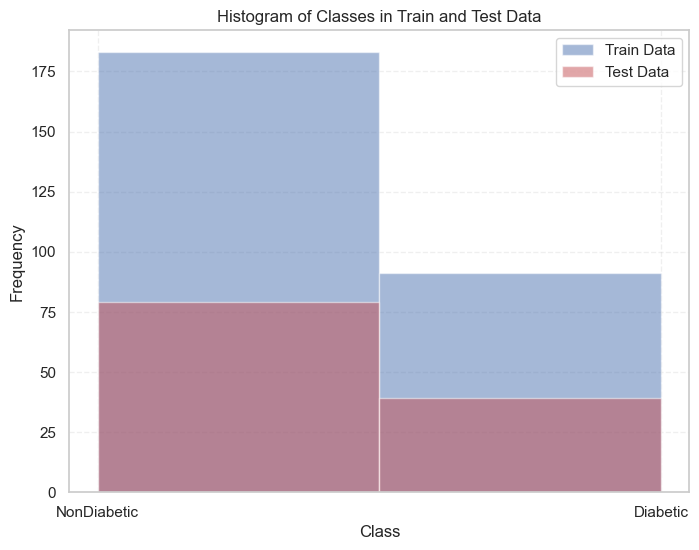

In [24]:
# Training Data------------------------------

# Data Splitting------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    transformed_df, diabetes_data['Outcome'], test_size=0.3, random_state=1, stratify=diabetes_data['Outcome']
)

# Histogram------------------------------
plt.figure(figsize=(8,6))
plt.hist(y_train, bins=2, alpha=0.5, color='b', label='Train Data')
plt.hist(y_test, bins=2, alpha=0.5, color='r', label='Test Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Classes in Train and Test Data')
plt.xticks([0, 1])
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.rc('font', size=12)
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

#Y variable in object ("Diabetic" and "NonDiabetic") format
original_y_train = y_train.copy()
original_y_test = y_test.copy()

# Convert Y variable to int format for most model input------------------------------
y_train = y_train.map({'NonDiabetic': 0, 'Diabetic': 1})
y_test = y_test.map({'NonDiabetic': 0, 'Diabetic': 1})

# Variables to store ROC curve data and metrics data------------------------------
roc_data = {}
combined_stats = pd.DataFrame()


In [25]:
# Function to save ROC plot data and send back performance metrics, when given the model, data and model/set names------------------------------ 
def ModelStats(model, X, y, model_name, setname, roc_data_dict):
	
        # Predictions on Data------------------------------
        if model_name.startswith('Partial'): 
            predictions = model.predict(X)
            probabilities = predictions.ravel()
            predictions = (predictions > 0.5).astype(int)
        elif model_name.startswith('Neural'):
            predictions = (model.predict(X) > 0.5).astype("int32")
            probabilities = model.predict(X)
        else:
            predictions = model.predict(X)
            probabilities = model.predict_proba(X)[:, 1]
        
        print(f"\n **********{model_name}: {setname} Set Results**********")

        # Confusion Matrix------------------------------
        conf_matrix = confusion_matrix(y, predictions)
        conf_matrix_percentage = (conf_matrix / conf_matrix.sum()) * 100
        print(f"\n Confusion Matrix(in%):\n{conf_matrix_percentage.round(0)}")

        # Extracting TN, FP, FN, and TP------------------------------
        TN, FP, FN, TP = conf_matrix_percentage.ravel()

        # Calculating Sensitivity (True Positive Rate)------------------------------
        sensitivity = round(TP / (TP + FN)*100,2)
        #print(f"\n Sensitivity(in%): {sensitivity:.2f}")

        # Calculating Specificity (True Negative Rate)------------------------------
        specificity = round(TN / (TN + FP)*100,2)
        #print(f"\n Specificity(in%): {specificity:.2f}")

        # AUC (Area Under the ROC Curve)------------------------------
        auc_score = round(roc_auc_score(y, probabilities)*100,2)
        #print(f"\n AUC(in%): {auc_score:.2f}")

        # Accuracy------------------------------
        accuracy = round(accuracy_score(y, predictions)*100,2)
        #print(f"\n Accuracy(in%): {accuracy:.2f}")

        # ROC Curve------------------------------
        fpr, tpr, _ = roc_curve(y, probabilities)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, label=f'{model_name}')
        plt.title(f'ROC Curve: {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        
        # Save FPR and TPR in the provided dictionary with a unique identifier------------------------------
        roc_id = f"{model_name}_{setname}"
        roc_data_dict[roc_id] = {'fpr': fpr, 'tpr': tpr}
    
        metrics_df = pd.DataFrame({
        'Model Name': [model_name],
        'Set Name': [setname],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'AUC Score': [auc_score],
        'Accuracy': [accuracy],
        'ROC ID': [roc_id]
        })
        
        return metrics_df


In [26]:
#Function to plot all the ROC plots in a single plot for comparison, diven the data set and set name------------------------------
def plot_combined_roc(roc_data, setname):
    fig = go.Figure()

    for roc_id, roc_values in roc_data.items():
        dict_setname = roc_id.split('_')[-1]
        if dict_setname == setname:
            fig.add_trace(go.Scatter(x=roc_values['fpr'], y=roc_values['tpr'], mode='lines', name=roc_id, hovertemplate=f'{roc_id}<extra></extra>'))

    fig.add_shape(type='line', x0=0, y0=0, x1=1, y1=1, line=dict(color='navy', width=2, dash='dash'))
    fig.update_xaxes(range=[0, 1])
    fig.update_yaxes(range=[0, 1.05])
    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title=f'Receiver Operating Characteristic (ROC) - {setname}',
        legend=dict(x=0.5, y=0.01),
    )

    fig.show()

In [27]:
# Function to extract model summary when given the model and variable names and sort them as per coefficient values------------------------------
def model_summary(model, columns):
    #coefficients = model.coef_
    #intercept = model.intercept_[0]
    #model_summary_df = pd.DataFrame({'Intercept': [intercept], **dict(zip(columns, coefficients[0]))})
    coef_df = pd.DataFrame({'Feature': columns, 'Coefficient': model.coef_[0].round(2)}) 
    return display_dataframe(coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index))

### 1. Logistic Regression Model

In [28]:
# Logistic Regression Model------------------------------

# Set up the range of hyperparameters
penalty_options = ['l1', 'l2']
solver_options = ['liblinear', 'saga']  # 'saga' supports both 'l1' and 'l2' penalties
Cs_values = [0.001, 0.01, 0.1, 1, 10, 100]

logistic_model = LogisticRegressionCV(
    Cs=Cs_values,
    cv=5,
    scoring='roc_auc',
    max_iter=12,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
logistic_model.fit(X_train, y_train)

print("Logistic Regression Model Summary:")
model_summary(logistic_model,X_train.columns)

Logistic Regression Model Summary:


Feature  Coefficient
                   Glucose         0.33
                       Age         0.24
                   Insulin         0.18
                       BMI         0.16
             SkinThickness         0.14
  DiabetesPedigreeFunction         0.14
             BloodPressure         0.10
               Pregnancies         0.08

- Glucose, Age and Insulin are significant predictors of diabetes, consistent with medical understanding.
- The positive coefficients for all the variables suggest their roles as risk factors, although their impact is less pronounced than glucose, Age and Insulin.
- The model could be improved by addressing the false positives and negatives, possibly through feature engineering(not pursued within this exercise).


 **********Logistic Model: Training Set Results**********

 Confusion Matrix(in%):
[[47. 20.]
 [ 5. 28.]]


Model Name  Set Name  Sensitivity  Specificity  AUC Score  Accuracy  \
  Logistic Model  Training        85.71        70.49      86.94     75.55   

                   ROC ID  
  Logistic Model_Training

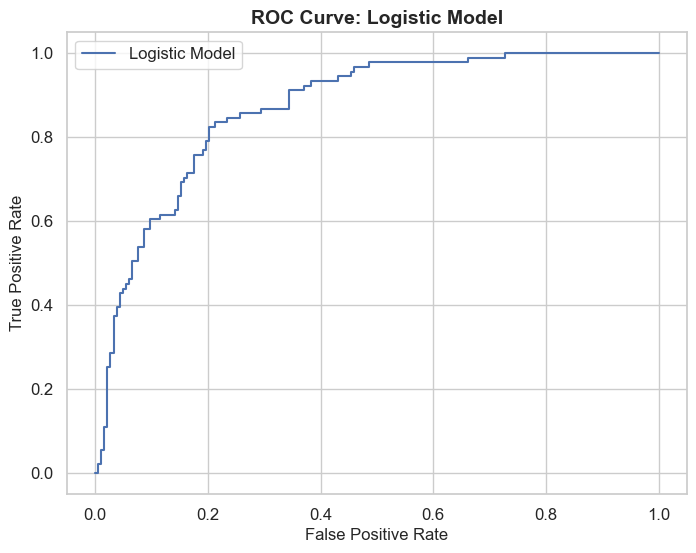

In [29]:
logistic_stat = ModelStats(logistic_model, X_train, y_train, 'Logistic Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, logistic_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(logistic_stat)

### 2. Linear Discriminant Analysis Model

In [30]:
# Linear Discriminant Analysis Model------------------------------
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

print("Linear Discriminant Analysis Model Summary:")
model_summary(lda_model,X_train.columns)

Linear Discriminant Analysis Model Summary:


Feature  Coefficient
                   Glucose         1.24
                       Age         0.71
  DiabetesPedigreeFunction         0.37
                       BMI         0.31
             SkinThickness         0.20
             BloodPressure         0.05
                   Insulin         0.05
               Pregnancies         0.00

- Glucose, Age and DiabetesPedigreeFunction are significant predictors of diabetes.
- The LDA model seems to emphasize the importance of Glucose and Age much more than the Logistic Regression model does. This could be due to the differences in how the two models handle the data. LDA assumes that the independent variables are normally distributed and have the same variance-covariance matrix across groups.


 **********Linear Discriminant Analysis Model: Training Set Results**********

 Confusion Matrix(in%):
[[59.  8.]
 [11. 22.]]


Model Name  Set Name  Sensitivity  Specificity  \
  Linear Discriminant Analysis Model  Training        65.93        87.98   

  AUC Score  Accuracy                                       ROC ID  
      87.64     80.66  Linear Discriminant Analysis Model_Training

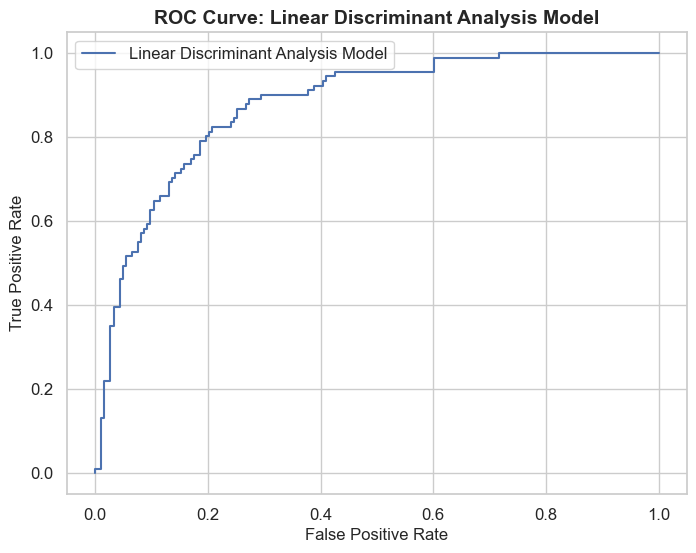

In [31]:
lda_stat = ModelStats(lda_model, X_train, y_train, 'Linear Discriminant Analysis Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, lda_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(lda_stat)

### 3. Partial Least Squares Discriminant Analysis Model

In [32]:
#Partial Least Squares Discriminant Analysis Model------------------------------

# Number of PLS components to use: n_components 
#plsda_model = PLSRegression(n_components=3) #n_components optimized by comparing training set metrics
#plsda_model.fit(X_train, y_train.to_numpy())
plsda_model = PLSRegression()

# Define the range of values to search for n_components
param_grid = {'n_components': np.arange(1, 8)}

# Perform a grid search with cross-validation to find the best n_components
grid_search = GridSearchCV(plsda_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best value of n_components
best_n_components = grid_search.best_params_['n_components']
print(f"Best n_components: {best_n_components}")

Best n_components: 5


In [33]:
# Fit the PLS-DA model with the best n_components on the training data
best_plsda_model = PLSRegression(n_components=best_n_components)
best_plsda_model.fit(X_train, y_train)

print("Partial Least Squares Discriminant Analysis Model Summary:")
components = best_plsda_model.n_components  # Number of components in the model
variable_names = X_train.columns

# Create a dictionary to store variable loadings for each component
variable_loadings = {}

# Loop through each component and store variable loadings
for component in range(components):
    loadings = best_plsda_model.x_loadings_[:, component]
    variable_loadings[f'Component {component + 1} Loadings'] = loadings

# Create a DataFrame to display variable loadings
pd.DataFrame(variable_loadings, index=variable_names).sort_values(by='Component 5 Loadings', ascending=False)

Partial Least Squares Discriminant Analysis Model Summary:


Component 1 Loadings  Component 2 Loadings  \
Insulin                               0.399980              0.180384   
BMI                                   0.369227             -0.503903   
Glucose                               0.476309              0.526353   
SkinThickness                         0.367492             -0.543289   
Age                                   0.430125              0.031965   
BloodPressure                         0.305147             -0.520380   
Pregnancies                           0.216336             -0.018807   
DiabetesPedigreeFunction              0.192318              0.364178   

                          Component 3 Loadings  Component 4 Loadings  \
Insulin                               0.688766              0.268479   
BMI                                  -0.407694              0.316589   
Glucose                              -0.149718             -0.034959   
SkinThickness                        -0.393129              0.211030   
Age                                   0.057108             -0.499487   
BloodPressure                        -0.135270             -0.138320   
Pregnancies                           0.529853             -0.563423   
DiabetesPedigreeFunction             -0.036863              0.487517   

                          Component 5 Loadings  
Insulin                               0.429460  
BMI                                   0.380712  
Glucose                               0.275497  
SkinThickness                        -0.095854  
Age                                  -0.185159  
BloodPressure                        -0.349163  
Pregnancies                          -0.378524  
DiabetesPedigreeFunction             -0.729335

- PLS-DA model seems to suggest a different effect on the Outcome from all the variables except Insulin, BMI and Glucose when compared to logistic regression model.
- DiabetesPedigreeFunction, Insulin and BMI are the most influential variables in the model.
- There could be multiple reasons why PLS-DA model has DiabetesPedigreeFunction as the most influetial variable, one of them being If DiabetesPedigreeFunction interacts with other variables in a way that is better captured by the PLS-DA method, this could result in a higher magnitude loading in PLS-DA and also in Linear Discriminant Analysis model above. We could verify if the variable is relevant through test set analysis.


 **********Partial Least Squares Discriminant Analysis Model: Training Set Results**********

 Confusion Matrix(in%):
[[59.  8.]
 [12. 22.]]


Model Name  Set Name  Sensitivity  \
  Partial Least Squares Discriminant Analysis Model  Training        64.84   

  Specificity  AUC Score  Accuracy  \
        88.52      87.61     80.66   

                                             ROC ID  
  Partial Least Squares Discriminant Analysis Mo...

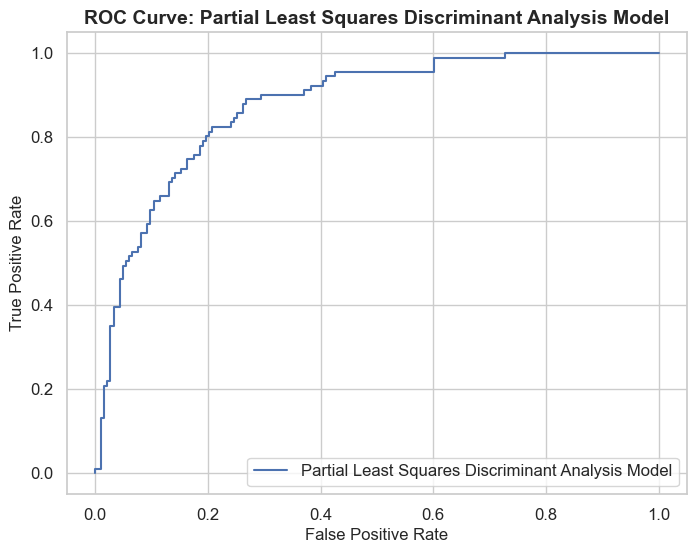

In [34]:
plsda_stat = ModelStats(best_plsda_model, X_train, y_train, 'Partial Least Squares Discriminant Analysis Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, plsda_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(plsda_stat)

### 4. Penalized Generalized Linear Model

In [35]:
#Penalized Generalized Linear Model------------------------------
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='liblinear'),  # Adding solver for compatibility
    {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    cv=5,
    scoring='roc_auc'
)

# Fit the efficient grid search model to the data
grid_search.fit(X_train, y_train)

# Best parameter and score
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters:  {'C': 0.001}
Best cross-validation score:  0.8585616318072459


In [36]:
#continued with the best parameter------------------------------
glm_model = LogisticRegression(penalty='l2', C=grid_search.best_params_['C'], solver='liblinear' )
glm_model.fit(X_train, y_train)

print("Penalized Generalized Linear Model Summary:")
model_summary(glm_model,X_train.columns)

Penalized Generalized Linear Model Summary:


Feature  Coefficient
                   Glucose         0.06
                   Insulin         0.04
                       Age         0.04
             BloodPressure         0.03
             SkinThickness         0.03
                       BMI         0.03
               Pregnancies         0.02
  DiabetesPedigreeFunction         0.02


 **********Penalized Generalized Linear Model: Training Set Results**********

 Confusion Matrix(in%):
[[53. 14.]
 [ 7. 26.]]


Model Name  Set Name  Sensitivity  Specificity  \
  Penalized Generalized Linear Model  Training        79.12        79.78   

  AUC Score  Accuracy                                       ROC ID  
      86.27     79.56  Penalized Generalized Linear Model_Training

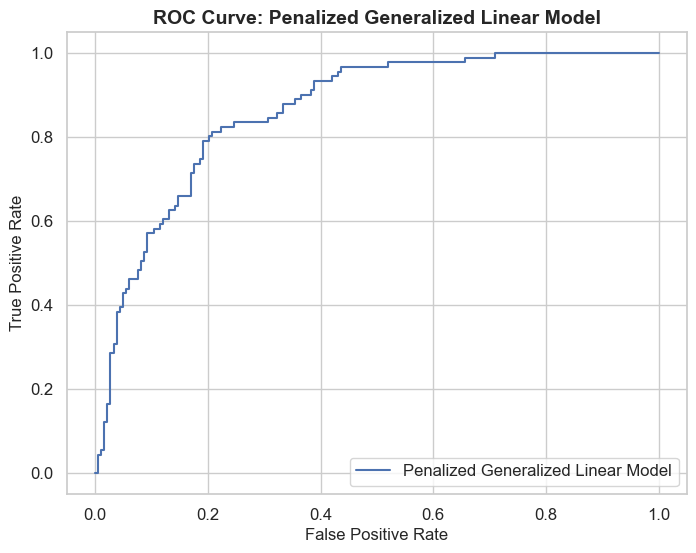

In [37]:
glm_stat = ModelStats(glm_model, X_train, y_train, 'Penalized Generalized Linear Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, glm_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(glm_stat)

### 5. Neural Network Model

In [38]:
# Neural Network Model------------------------------

# Define a model-building function for Keras Tuner------------------------------
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with the chosen optimizer and learning rate------------------------------
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC()]
    )
    return model

# Instantiate the Hyperband tuner------------------------------
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    directory='hyperband',
    project_name='nn_optimization'
)

# Start the hyperparameter tuning process------------------------------
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

# Retrieve the best model------------------------------
nn_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model------------------------------
nn_model.summary()

# Get the optimal hyperparameters------------------------------
nn_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from hyperband\nn_optimization\tuner0.json


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               4032      
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 449       
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


9/9 [==============================] - 0s 2ms/step

 **********Neural Network Model: Training Set Results**********

 Confusion Matrix(in%):
[[59.  8.]
 [12. 21.]]


Model Name  Set Name  Sensitivity  Specificity  AUC Score  \
  Neural Network Model  Training        62.64        87.98      86.41   

  Accuracy                         ROC ID  
     79.56  Neural Network Model_Training

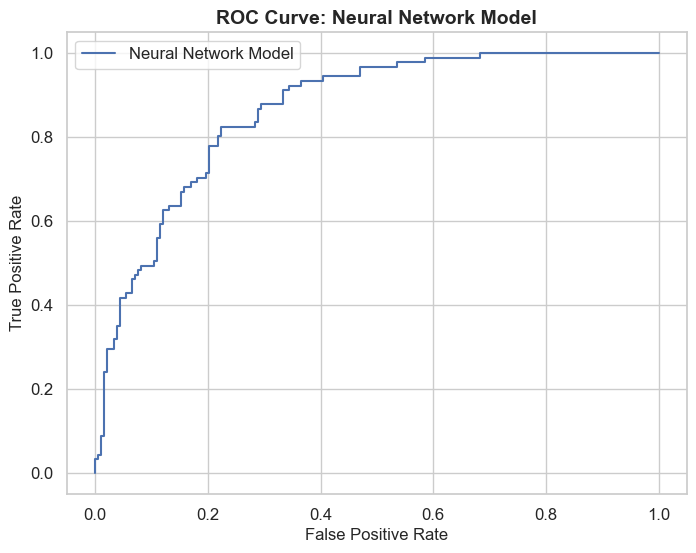

In [39]:
nn_stat = ModelStats(nn_model, X_train, y_train, 'Neural Network Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, nn_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(nn_stat)

### 6. Support Vector Machine Model


 **********Support Vector Machine Model: Training Set Results**********

 Confusion Matrix(in%):
[[61.  6.]
 [ 9. 24.]]


Model Name  Set Name  Sensitivity  Specificity  AUC Score  \
  Support Vector Machine Model  Training        73.63        91.26      93.41   

  Accuracy                                 ROC ID  
      85.4  Support Vector Machine Model_Training

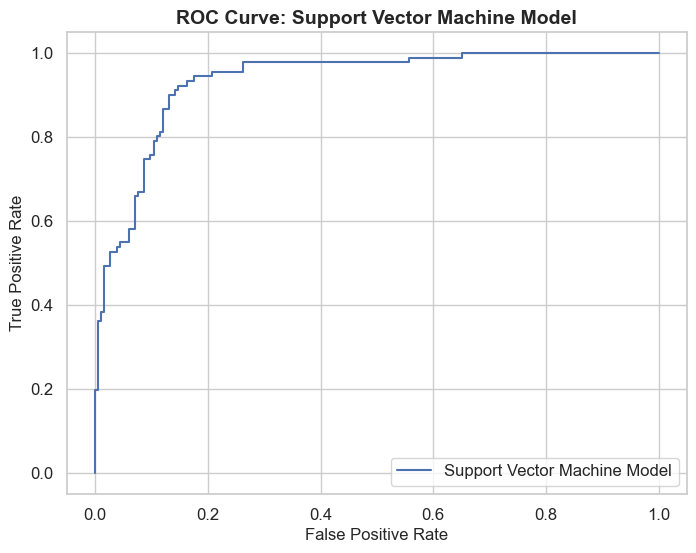

In [40]:
# Support Vector Machine Model------------------------------
svm_model = SVC(probability=True)  # 'probability=True' is needed for roc_auc_score
svm_model.fit(X_train, y_train)

svm_stat = ModelStats(svm_model, X_train, y_train, 'Support Vector Machine Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, svm_stat]).reset_index(drop=True).drop(columns=['ROC ID']).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(svm_stat)

### 7. KNN Model

Best Parameters: {'n_neighbors': 5}

 **********Knn Model: Training Set Results**********

 Confusion Matrix(in%):
[[60.  7.]
 [11. 22.]]


Model Name  Set Name  Sensitivity  Specificity  AUC Score  Accuracy  \
  Knn Model  Training        67.03        90.16      90.79     82.48   

              ROC ID  
  Knn Model_Training

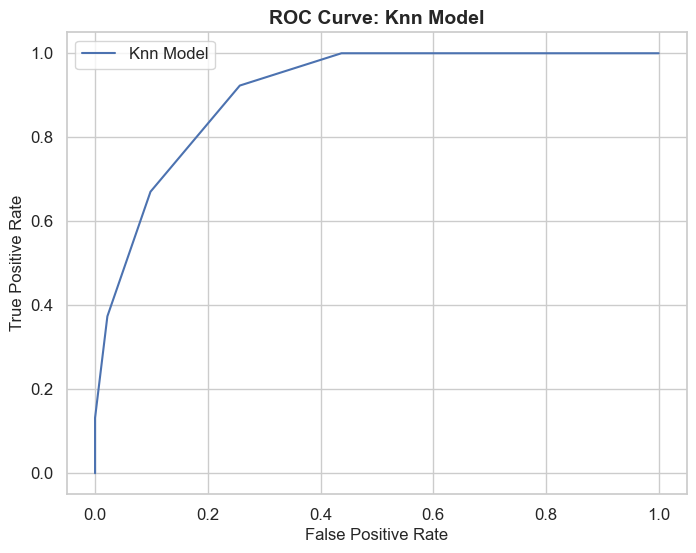

In [41]:
# KNN Model------------------------------

# Define a range of hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # You can adjust the range of neighbors to consider
}
knn_model = KNeighborsClassifier()

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator from the grid search
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Use the best model for predictions
knn_stat = ModelStats(best_knn_model, X_train, y_train, 'Knn Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, knn_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(knn_stat)

### 8. Naive Bayes Model


 **********Naive Bayes Model: Training Set Results**********

 Confusion Matrix(in%):
[[55. 12.]
 [ 8. 25.]]


Model Name  Set Name  Sensitivity  Specificity  AUC Score  Accuracy  \
  Naive Bayes Model  Training        74.73        82.51      87.56     79.93   

                      ROC ID  
  Naive Bayes Model_Training

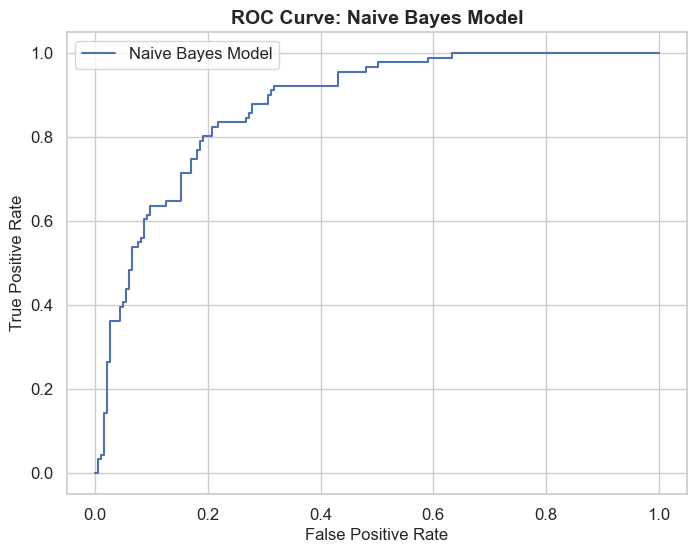

In [42]:
# Naive Bayes Model------------------------------
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_stat = ModelStats(nb_model, X_train, y_train, 'Naive Bayes Model', 'Training', roc_data)
combined_stats = pd.concat([combined_stats, nb_stat]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(nb_stat)

## Training Model Comparison

In [43]:
plot_combined_roc(roc_data, "Training")

In [44]:
display_dataframe(combined_stats[combined_stats['Set Name'] == 'Training'].drop(columns=['ROC ID']).sort_values(by='AUC Score', ascending=False))

Model Name  Set Name  Sensitivity  \
                       Support Vector Machine Model  Training        73.63   
                                          Knn Model  Training        67.03   
                 Linear Discriminant Analysis Model  Training        65.93   
  Partial Least Squares Discriminant Analysis Model  Training        64.84   
                                  Naive Bayes Model  Training        74.73   
                                     Logistic Model  Training        85.71   
                               Neural Network Model  Training        62.64   
                 Penalized Generalized Linear Model  Training        79.12   

  Specificity  AUC Score  Accuracy  
        91.26      93.41     85.40  
        90.16      90.79     82.48  
        87.98      87.64     80.66  
        88.52      87.61     80.66  
        82.51      87.56     79.93  
        70.49      86.94     75.55  
        87.98      86.41     79.56  
        79.78      86.27     79.56

In choosing models to proceed with test set analysis, in certain scenarios, when we are interested in the interpretability of the model we could choose the Linear Discriminant Analysis Model and the Partial Least Squares Discriminant Analysis Model. If we are constrained by the cost of false positives and false negatives, particularly for a binary classification model, we typically look at a combination of metrics that indicate both the model's ability to identify positive cases (Sensitivity) and its ability to identify negative cases (Specificity), as well as its overall performance in correctly classifying cases (Accuracy) and its discriminative abilities (AUC Score). We will proceed with this approach on our dataset.	

Based on the provided data, here are two models I would recommend for proceeding with test set analysis:

1. Support Vector Machine Model: The SVM model exhibits excellent performance on the training set, with the highest AUC Score (93.41) and a good balance between Sensitivity and Specificity. This suggests that it can effectively distinguish between positive and negative cases while maintaining a high overall accuracy. Given its strong training performance, it is a strong candidate for evaluation on the test set.

2. Knn Model: The KNN model also demonstrates good performance on the training set, with a competitive AUC Score (90.79) and a reasonable balance between Sensitivity and Specificity. While it may not have as high Sensitivity as the SVM model, it still offers a good trade-off between various metrics. Given its solid training performance, it's a suitable choice for evaluation on the test set.

These two models show a balanced performance across all the key metrics, making them suitable for further evaluation on a test set.

## MODEL TESTING


 **********Support Vector Machine Model: Testing Set Results**********

 Confusion Matrix(in%):
[[56. 11.]
 [15. 18.]]


Model Name Set Name  Sensitivity  Specificity  AUC Score  \
  Support Vector Machine Model  Testing        53.85        83.54      81.73   

  Accuracy                                ROC ID  
     73.73  Support Vector Machine Model_Testing

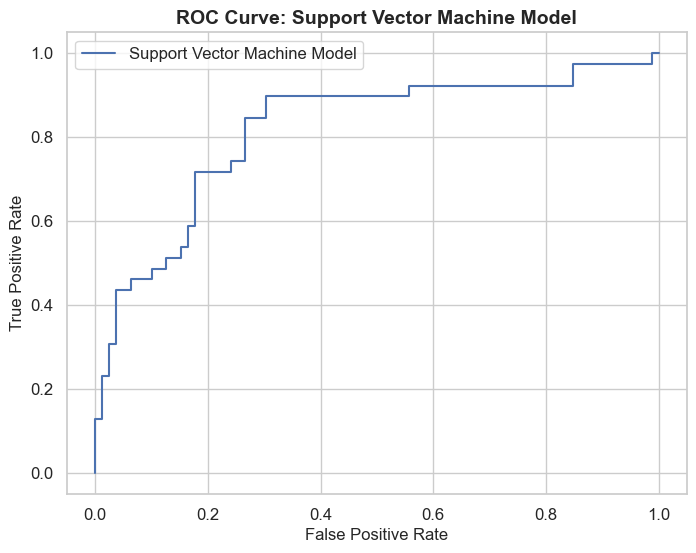

In [45]:
# Support Vector Machine Model - Testing------------------------------
svm_stat2 = ModelStats(svm_model, X_test, y_test, 'Support Vector Machine Model', 'Testing', roc_data)
combined_stats = pd.concat([combined_stats, svm_stat2]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(svm_stat2)


 **********Knn Model: Testing Set Results**********

 Confusion Matrix(in%):
[[57. 10.]
 [16. 17.]]


Model Name Set Name  Sensitivity  Specificity  AUC Score  Accuracy  \
  Knn Model  Testing        51.28        84.81      76.01     73.73   

             ROC ID  
  Knn Model_Testing

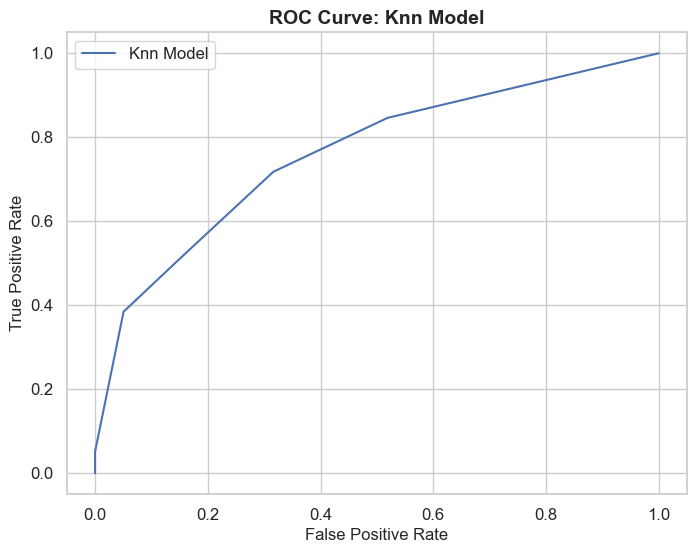

In [46]:
# KNN Model - Testing------------------------------
knn_stat2 = ModelStats(best_knn_model, X_test, y_test, 'Knn Model', 'Testing', roc_data)
combined_stats = pd.concat([combined_stats, knn_stat2]).reset_index(drop=True).drop_duplicates(subset=['Model Name', 'Set Name'])
display_dataframe(knn_stat2)

In [47]:
plot_combined_roc(roc_data, "Testing")

In [49]:
display_dataframe(combined_stats[combined_stats['Set Name'] == 'Testing'].drop(columns=['ROC ID']).sort_values(by='AUC Score', ascending=False))

Model Name Set Name  Sensitivity  Specificity  AUC Score  \
  Support Vector Machine Model  Testing        53.85        83.54      81.73   
                     Knn Model  Testing        51.28        84.81      76.01   

  Accuracy  
     73.73  
     73.73

## FINAL MODEL  RECOMMENDATION
The Support Vector Machine (SVM) Model is recommended as the final model. Here are the reasons for this recommendation:

- Higher AUC Score: The SVM model has an AUC Score of 81.69, compared to 76.01 for the Knn model. The AUC Score is a measure of the model's ability to discriminate between positive and negative classes. A higher AUC Score suggests that the SVM model has a better overall performance in distinguishing between the two classes.

- Higher Sensitivity: The SVM model has a higher Sensitivity (53.85%) compared to the Knn model (51.28%). Sensitivity measures the ability of a model to correctly identify positive cases. In this aspect, the SVM Model outperforms the Knn Model.

- Similar Specificity: The Specificity of the SVM model (83.54%) is comparable to that of the Knn model (84.81%). Specificity measures the ability of a model to correctly identify negative cases. While Knn has a slightly higher specificity, the difference is minimal.

- Similar Accuracy: Both the SVM and Knn models have similar Accuracy, with the SVM model and the Knn model at 73.73%.

Considering the performance metrics from the test set, the SVM model shows a slight advantage over the Knn model in terms of AUC Score and Sensitivity. The differences in Specificity and Accuracy are not substantial, making the SVM model a better choice overall for deployment in this binary classification task. 